In [1]:
import gzip
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


In [2]:
def parse_jsongz(jsongz_path):
    json_array = []
    count = 0
    with gzip.open(jsongz_path, 'rt', encoding='utf-8') as zipfile:
        for line in tqdm(zipfile):
            rjson = json.loads(line)
            json_array.append(rjson)
            count += 1
            if count > 4000000:
                break
    return pd.json_normalize(json_array)

In [3]:
review_path = "D://data//amazon//reviews_Books_5.json.gz"
review_df = parse_jsongz(review_path)

4000000it [00:59, 67028.80it/s]


In [4]:
review_df['hf'] = review_df['helpful'].apply(lambda x: sum(x))
review_df['label'] = review_df['overall'].apply(lambda x: 0 if x < 3 else 1)

In [5]:
review_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,hf,label
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5.0,Wonderful!,1355616000,"12 16, 2012",0,1
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5.0,close to god,1071100800,"12 11, 2003",2,1
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5.0,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,1
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5.0,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,1
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5.0,A Modern Rumi,1033948800,"10 7, 2002",16,1
...,...,...,...,...,...,...,...,...,...,...,...
3999996,ANMQVHDLG3BSI,080214179X,Lyle W. Gray,"[4, 5]",The first night I began this book I had troubl...,5.0,"Makes one proud of the phrase, ""We support our...",1113264000,"04 12, 2005",9,1
3999997,A1DZM8XBA41218,080214179X,Manchu 19,"[1, 1]",If you want to know what Soldiers fight for - ...,5.0,Perhaps the New Greatest Generation,1140480000,"02 21, 2006",2,1
3999998,A3OG7EHKGKZJ2L,080214179X,Mary A. Ward,"[5, 5]",David Zucchino pulls the veil back and educate...,5.0,3rd ID TF 1-64 Mom Appreciates the Details of ...,1108512000,"02 16, 2005",10,1
3999999,AVQ9T0BC4PCVS,080214179X,"Pangloss ""soldierblue""","[10, 10]",There are currently many books out about the I...,5.0,Excellent story about the war in Iraq,1089417600,"07 10, 2004",20,1


In [6]:
from dcn import DCN, get_auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
lr = 1e-2
wd = 1e-3
epoches = 20
seed = 2022
embedding_size = 8

sparse_feature = ['reviewerID', 'asin']
dense_feature = ['hf']
col_names = ['label'] + dense_feature + sparse_feature
# data = pd.read_csv('./data/dac_sample.txt', names=col_names, sep='\t')
data = review_df[col_names]
data[sparse_feature] = data[sparse_feature].fillna('-1', )
data[dense_feature] = data[dense_feature].fillna('0', )
target = ['label']

feat_sizes = {}
feat_sizes_dense = {feat: 1 for feat in dense_feature}
feat_sizes_sparse = {feat: len(data[feat].unique()) for feat in sparse_feature}
feat_sizes.update(feat_sizes_dense)
feat_sizes.update(feat_sizes_sparse)

for feat in sparse_feature:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
nms = MinMaxScaler(feature_range=(0, 1))
data[dense_feature] = nms.fit_transform(data[dense_feature])

fixlen_feature_columns = [(feat, 'sparse') for feat in sparse_feature] + [(feat, 'dense') for feat in dense_feature]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
train, test = train_test_split(data, test_size=0.1, random_state=seed)

model = DCN(feat_sizes, embedding_size, linear_feature_columns, dnn_feature_columns).to(device)

train_label = pd.DataFrame(train['label'])
train = train.drop(columns=['label'])
# print(train)
train_tensor_data = TensorDataset(torch.from_numpy(np.array(train)), torch.from_numpy(np.array(train_label)))
train_loader = DataLoader(train_tensor_data, shuffle=True, batch_size=batch_size)

test_label = pd.DataFrame(test['label'])
test = test.drop(columns=['label'])
test_tensor_data = TensorDataset(torch.from_numpy(np.array(test)), torch.from_numpy(np.array(test_label)))
test_loader = DataLoader(test_tensor_data, batch_size=batch_size)

loss_func = nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#定义两个数组
Loss_list = []
Accuracy_list = []

for epoch in range(epoches):
    total_loss_epoch = 0.0
    total_tmp = 0
    model.train()
    for index, (x, y) in enumerate(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        y_hat = model(x)
        optimizer.zero_grad()
        loss = loss_func(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss_epoch += loss.item()
        total_tmp += 1
    auc = get_auc(test_loader, model)
    Loss_list.append(total_loss_epoch / total_tmp / (len(train)))
    Accuracy_list.append(auc)
    print('epoch/epoches: {}/{}, train loss: {:.3f}, test auc: {:.3f}'.format(epoch, epoches,
                                                                              total_loss_epoch / total_tmp, auc))

D:\software\dev\Anaconda3\envs\env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\software\dev\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\software\dev\Anaconda3\envs\env\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

epoch/epoches: 0/20, train loss: 2.613, test auc: 0.500
epoch/epoches: 1/20, train loss: 4.202, test auc: 0.500
epoch/epoches: 2/20, train loss: 4.366, test auc: 0.500
epoch/epoches: 3/20, train loss: 2.921, test auc: 0.527
epoch/epoches: 4/20, train loss: 0.466, test auc: 0.604
epoch/epoches: 5/20, train loss: 0.886, test auc: 0.613
epoch/epoches: 6/20, train loss: 1.173, test auc: 0.612
epoch/epoches: 7/20, train loss: 3.944, test auc: 0.500
epoch/epoches: 8/20, train loss: 4.796, test auc: 0.500
epoch/epoches: 9/20, train loss: 4.800, test auc: 0.500
epoch/epoches: 10/20, train loss: 4.248, test auc: 0.500
epoch/epoches: 11/20, train loss: 4.875, test auc: 0.500
epoch/epoches: 12/20, train loss: 4.481, test auc: 0.500
epoch/epoches: 13/20, train loss: 4.216, test auc: 0.500
epoch/epoches: 14/20, train loss: 4.801, test auc: 0.500
epoch/epoches: 15/20, train loss: 4.458, test auc: 0.556
epoch/epoches: 16/20, train loss: 0.354, test auc: 0.581
epoch/epoches: 17/20, train loss: 0.359, 

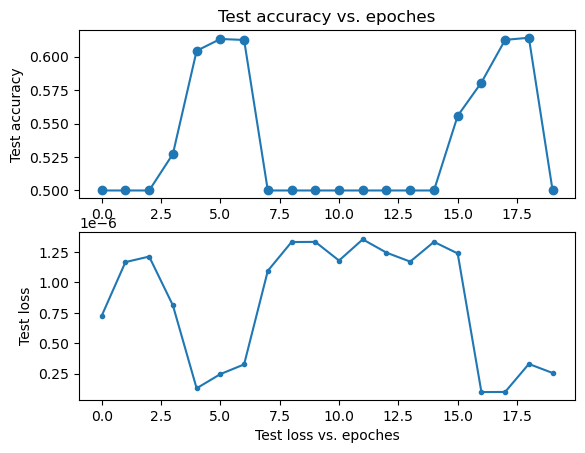

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pylab as plt

x1 = range(epoches)
x2 = range(epoches)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
plt.savefig("accuracy_loss.jpg")